In [3]:
"""""
 *  \brief     torch_test.ipynb
 *  \author    Jonathan Reymond
 *  \version   1.0
 *  \date      2023-02-14
 *  \pre       None
 *  \copyright (c) 2022 CSEM
 *
 *   CSEM S.A.
 *   Jaquet-Droz 1
 *   CH-2000 Neuchâtel
 *   http://www.csem.ch
 *
 *
 *   THIS PROGRAM IS CONFIDENTIAL AND CANNOT BE DISTRIBUTED
 *   WITHOUT THE CSEM PRIOR WRITTEN AGREEMENT.
 *
 *   CSEM is the owner of this source code and is authorised to use, to modify
 *   and to keep confidential all new modifications of this code.
 *
 """

os.chdir('/local/user/jrn/tinyml-challenge-2022')
sys.path.insert(0, '/local/user/jrn/tinyml-challenge-2022/ml_training')
sys.path.insert(0, '/local/user/jrn/tinyml-challenge-2022/ml_training/preprocess_data')
from preprocess_data.prepare_data import get_final_dataframe
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tf_to_tflite import *
from tensorflow import keras
from sklearn.model_selection import train_test_split
from constants_ml import *
from sklearn.metrics import classification_report, confusion_matrix
from models import models_dict
import random
from utils import *

import dataloader
from collections import Counter





## Tflite model generation correction

In [39]:
lowpass_freq = None
merge_bucket_size = 1
resample_frequency = None #SAMPLING_FREQUENCY / 2
to_mfcc = False
index_hours = range(85, 89)
df = get_final_dataframe(merge_bucket_size, lowpass_freq, resample_frequency, to_mfcc, index_hours)
X = df['audio'].to_list()
labels = df['rain_count'].to_numpy()

    
X_list = [np.split(xi, SPLIT_FACTOR) for xi in X]
X = list(itertools.chain.from_iterable(X_list))
X = np.expand_dims(X, axis=-1)
labels = np.repeat(labels, SPLIT_FACTOR)

Dataset already computed, loading from pickle


In [41]:
df.columns

Index(['timestamp', 'humidity', 'pressure', 'temperature', 'audio', 'wind_dir',
       'wind_count', 'rain_count', 'wind_x', 'wind_y'],
      dtype='object')

In [40]:
len(X)

10996

In [6]:
model = models_dict['m5'](X[0].shape[0], 3)
model.load_weights(CHECKPOINT_FILEPATH)


Using Model M5


2022-11-14 16:35:45.647963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:35:45.648578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:35:45.649081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-14 16:35:45.649139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-14 16:35:45.649193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

In [64]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=160,
    layer_range=None,
    show_layer_activations=False,
)
print(model.summary())


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1639, 19)          1349      
                                                                 
 batch_normalization (BatchN  (None, 1639, 19)         76        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1639, 19)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 409, 19)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)

In [7]:
x_tr, x_te, y_tr, y_te = train_test_split(X, labels, test_size=0.3, random_state=1)


In [14]:
def representative_data_gen(X):
    for xi in X:
        # need reshape (batch=1, size=32000, channel=1)
        yield [np.array(xi, dtype=np.float32).reshape((1,-1, 1))]

def get_tflite_interpreter2(model, with_optimization, with_quantization, store_path=None, X=None):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if with_optimization:
        converter.optimizations = [tf.lite.Optimize.EXPERIMENTAL_SPARSITY, tf.lite.Optimize.DEFAULT]
    if with_quantization:
        X_r = X[5000:]
        np.random.shuffle(X_r)
        converter.representative_dataset = lambda : representative_data_gen(X_r)
        # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] 
    tflite_model_ = converter.convert()
    if store_path is not None:
        tflite_model_file = pathlib.Path(store_path)
        tflite_model_file.write_bytes(tflite_model_)

    interpreter = tf.lite.Interpreter(model_content=tflite_model_)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]['index']
    output_details = interpreter.get_output_details()[0]['index']
    return {'interpreter': interpreter, 'input':input_details, 'output':output_details}

def is_correct(labels, outputs):
    pred = outputs.argmax(axis=2)
    return np.equal(labels, pred).astype(int)

# for multiple inputs
def tflite_eval(interpreter_dict, X):
    interpreter = interpreter_dict['interpreter']
    res = []
    for i in range(len(X)):
        if (i + 1)% 100 == 0 :
            print('tflite evaluation :', i + 1, len(X), end="\r")
        
        interpreter.set_tensor(interpreter_dict['input'], X[i])
        interpreter.invoke()
        output_sample = interpreter.get_tensor(interpreter_dict['output'])
        res.append(output_sample)
    print()
    return np.asarray(res)

# for multiple inputs
def tf_eval(tf_model, X):
    infer_tf_model = tf_model.signatures["serving_default"]
    res = []
    for i in range(len(X)):
        if (i  + 1) % 100  == 0 :
            print('tf evaluation :', i + 1, len(X), end="\r")
        output_sample = infer_tf_model(X[i])['dense_2'].numpy()
        res.append(output_sample)
    print()
    return res

In [15]:
tflite_model = get_tflite_interpreter2(model, True, True, store_path="/local/user/jrn/tinyml-challenge-2022/results/m_test.tflite", X=X)

INFO:tensorflow:Assets written to: /tmp/tmpt2clzg17/assets


INFO:tensorflow:Assets written to: /tmp/tmpt2clzg17/assets
2022-11-14 16:47:04.177458: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-11-14 16:47:04.177482: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-11-14 16:47:04.177659: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpt2clzg17
2022-11-14 16:47:04.182251: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-11-14 16:47:04.182266: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpt2clzg17
2022-11-14 16:47:04.200302: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-11-14 16:47:04.250867: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpt2clzg17
2022-11-14 16:47:04.278226: I tensorflow/cc/saved_model/loader.cc:301] SavedMode

In [16]:

x_te_tflite = [tf.convert_to_tensor(xi.reshape(1, -1, 1)) for xi in x_te]
res_tflite = tflite_eval(tflite_model, x_te_tflite)


tflite evaluation : 3200 3299


In [17]:
res_tflite[:20]

array([[[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.94140625, 0.05078125, 0.0078125 ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.00390625, 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.53125   , 0.375     , 0.09375   ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.99609375, 0.        , 0.        ]],

       [[0.20703125, 0.6484375 , 0.14453125]]], dtype=float32)

In [31]:
res_tflite[:, :, 0]

array([[0.09609374],
       [0.09609374],
       [0.09609374],
       ...,
       [0.09609374],
       [0.09609374],
       [0.09609374]], dtype=float32)

In [37]:
res_tflite[:, :, 0] += 0.02 
pred_tflite = np.argmax(res_tflite, 2).flatten()

# print(confusion_matrix(pred_tf, labels_test))
print(confusion_matrix(pred_tflite, y_te))

acc = np.sum((pred_tflite == y_te).astype(np.int16)) / len(y_te)
print(acc)

[[2327  543  154]
 [ 106   94   61]
 [   6    1    7]]
0.7359806001818733


In [19]:
y_pred = np.asarray(model.predict(x_te, verbose=0))
y_pred = y_pred.argmax(axis=1)

print(confusion_matrix(y_pred, y_te))
acc = np.sum((y_pred == y_te).astype(np.int16)) / len(y_te)
print(acc)

[[2081  144   13]
 [ 245  385   63]
 [ 113  109  146]]
0.7917550772961504


## Test values

In [ ]:
def wav_to_pcm(arr):
    arr = arr.reshape((-1))
    res = []
    for val in arr :
        val = val* 2**15
        if val < 0 :
            val += 2**16
        res.append(int(val))
    return res
    

In [ ]:
zeros_wav = np.zeros((1, 4096, 1), dtype=np.float32)
zeros_pcm = wav_to_pcm(zeros_wav)
print('zero value:', tflite_eval(tflite_interp_quant, [zeros_wav]))
# print('pcm:', zeros_pcm)
# print('wav:', list(zeros_wav.reshape((-1))))


In [ ]:
wav = (np.arange(4096* 10, step = 10)/ 409600).reshape((1, 4096, 1)).astype(np.float32)

zeros_pcm = wav_to_pcm(zeros_wav)
print('zero value:', tflite_eval(tflite_interp_quant, [wav]))

In [ ]:
sample_wav = np.array(X_test[2100], dtype=np.float32)
sample_pcm = wav_to_pcm(sample_wav)
print('sample value:', tflite_eval(tflite_interp_quant, [sample_wav]))
print('pcm:', sample_pcm)
print()
print('wav:', list(sample_wav.reshape((-1))))

## Plots

In [4]:
# Final 
arr1 = [[584,  40,  38],
 [ 59, 176,  77],
 [  9,  27, 101]]
acc1 = 0.7749775052070618

arr2 = [[584,  78],
 [ 68, 381]]
acc2 = 0.8685868586858686



# arr1 = [[1816,  514 ,  30],
#  [ 598, 1513,  350],
#  [  44,  393, 1437]]

# arr2 = [[4441,  380],
#  [ 437, 1437]]



name = 'rain'

if name == 'rain':
    # arr1=[[9270,  397,   68],
    # [1035, 1481,  205],
    # [  55,  192,  687]]
    
    arr1 = [[4990,  778,  104],
        [ 338, 1232,  247],
        [   0 ,  75,  604]]


    # arr2=[[12183,   273],
    # [  247,   687]]
    arr2 = [[7338, 351],
            [75,  604]]
else :
    #wind
    arr1=[[3362, 1235 ,  47],
     [1104, 3315 , 504],
     [  78,  996 ,2749]]

    arr2=[[9016,  551],
     [1074, 2749]]

arr1 = np.asarray(arr1, dtype=np.int16)
arr1 = arr1 / arr1.sum(axis=1).reshape((1, -1)).T

arr2 = np.asarray(arr2, dtype=np.int16)
arr2 = arr2 / arr2.sum(axis=1).reshape((1, -1)).T


In [2]:
[4990+ 778 + 338 + 1232, 104 + 247]

[7338, 351]

Text(14.999999999999996, 0.5, 'ground truth')

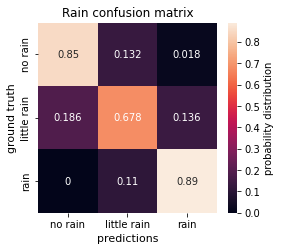

In [5]:


df_cm = pd.DataFrame(np.around(arr1, 3), index = [i for i in ['no ' + name, 'little ' + name, name]],
                  columns = ['no ' + name, 'little ' + name, name])
plt.figure(figsize = (4,3.5))
sns.heatmap(df_cm, annot=True, fmt='g', cbar_kws={'label': 'probability distribution'}).set_title(name.title() + ' confusion matrix')
plt.xlabel('predictions', fontsize=11)
plt.ylabel('ground truth', fontsize=11)
# plt.savefig('confusion_matrix_' + name +'.png', dpi=150)

Text(14.999999999999996, 0.5, 'ground truth')

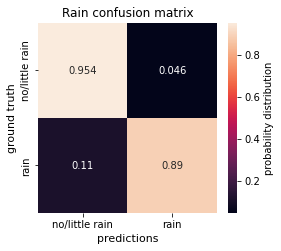

In [6]:
df_cm = pd.DataFrame(np.around(arr2, 3), index = [i for i in ['no/little ' + name, name]],
                  columns = ['no/little ' + name, name])
plt.figure(figsize = (4,3.5))
sns.heatmap(df_cm, annot=True, fmt='g', cbar_kws={'label': 'probability distribution'}).set_title(name.title() + ' confusion matrix')
plt.xlabel('predictions', fontsize=11)
plt.ylabel('ground truth', fontsize=11)
# plt.savefig('confusion_matrix_' + name + '_binary.png', dpi=150)

## Draft 

In [3]:
df = dataloader.get_dataset()

extracting dataset
[=================================> ]  100.0%   24/24


In [30]:
def compress_labels2(x):
    if x < 6:
        return 0
    elif x < 12:
        return 1
    else :
        return 2

<AxesSubplot:xlabel='wind_count', ylabel='Count'>

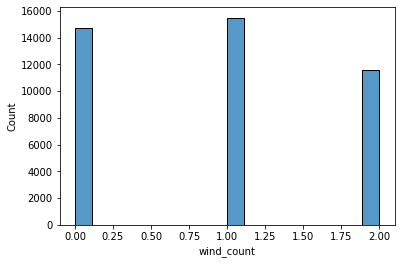

In [31]:
sns.histplot(df['wind_count'].map(compress_labels2))

<AxesSubplot:xlabel='wind_count', ylabel='Count'>

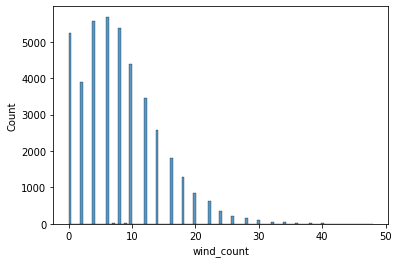

In [19]:
sns.histplot(df['wind_count'])

In [12]:
sorted(Counter(df['wind_count']).items())

[(0.0, 5243),
 (1.0, 1),
 (2.0, 3908),
 (3.0, 2),
 (4.0, 5583),
 (5.0, 4),
 (6.0, 5689),
 (7.0, 12),
 (8.0, 5373),
 (9.0, 12),
 (10.0, 4393),
 (11.0, 7),
 (12.0, 3452),
 (13.0, 5),
 (14.0, 2569),
 (15.0, 8),
 (16.0, 1807),
 (17.0, 2),
 (18.0, 1291),
 (19.0, 4),
 (20.0, 853),
 (21.0, 3),
 (22.0, 626),
 (23.0, 2),
 (24.0, 341),
 (26.0, 220),
 (28.0, 158),
 (29.0, 2),
 (30.0, 107),
 (32.0, 57),
 (34.0, 50),
 (36.0, 25),
 (38.0, 11),
 (40.0, 11),
 (42.0, 5),
 (44.0, 2),
 (46.0, 2),
 (48.0, 3)]

In [9]:
df = pd.read_pickle('/local/user/jrn/tinyml-challenge-2022/final_dataset_86_87_88.pkl')


,timestamp,humidity,pressure,temperature,audio,wind_dir,wind_count,rain_count,wind_x,wind_y
0,306002.389,0.884332,0.115592,0.185033,"[-0.05419922, -0.0541687, -0.0541687, -0.05419...",0.714286,0.0,0.0,0.500000,0.470588
1,306014.653,0.883627,0.110173,0.185033,"[-0.054473877, -0.05444336, -0.054504395, -0.0...",0.714286,0.0,0.0,0.500000,0.470588
2,306016.697,0.883479,0.116900,0.186590,"[-0.05456543, -0.054504395, -0.054382324, -0.0...",0.714286,0.0,0.0,0.500000,0.470588
3,306018.741,0.884464,0.109880,0.185967,"[-0.054504395, -0.054534912, -0.054504395, -0....",0.714286,0.0,0.0,0.500000,0.470588
4,306020.785,0.884464,0.109880,0.185967,"[-0.0546875, -0.0546875, -0.054626465, -0.0545...",0.714286,0.0,0.0,0.500000,0.470588
...,...,...,...,...,...,...,...,...,...,...
1028,319280.677,0.889803,0.147411,0.236120,"[-0.055145264, -0.055023193, -0.054992676, -0....",0.142857,4.0,1.0,0.588388,0.553777
1029,319284.765,0.890297,0.146627,0.235809,"[-0.054504395, -0.05456543, -0.054656982, -0.0...",0.285714,8.0,1.0,0.500000,0.705882
1030,319286.809,0.890991,0.148524,0.235497,"[-0.055419922, -0.055419922, -0.055114746, -0....",0.285714,8.0,1.0,0.500000,0.705882
1031,319288.853,0.891607,0.152053,0.235809,"[-0.05532837, -0.05529785, -0.05529785, -0.055...",0.285714,8.0,1.0,0.500000,0.705882


In [8]:
df['rain_count'].value_counts()

0.0    4053
1.0    1027
2.0     418
Name: rain_count, dtype: int64

## one hot encoding test

In [4]:
labels_rain = [0,2,4,1,1,1,3,3,2]
labels_wind = [1,2,3,0,0,1,3,1,2]
X = [0]
reformat_dataset(X, (labels_rain, labels_wind), True)

(array([[0]]),
 array([[1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0.]]),
 [5, 4])